# EXPLORING GENDER PAY GAPS IN THE UNITED STATES

## INTRODUCTION

Although the gender pay gap between men and women has reduced considerably since the early 1980s, it remains an issue. In the past two decades, women earned an average of 80% of what men earned and this gap has stayed relatively consistent (Kochhar, 2023). As the dataset catagorised salary into two groups: those who earn $\$50,000$ or less and those who earn more than $\$50,000$ instead of specific numbers, it would be most appropriate to investigate the latter category. As a result, we are interested in investigating gender pay gaps, especially in higher paying jobs (pay more than $\$50,000$ annually). Therefore, the question to be answered is, "Are women underrepresented in higher-paying occupations relative to their share of the workforce?". 

## METHODOLOGY

The “Census Income” data from the UCI Machine Learning Repository was chosen, which contains various education levels, job position and salary statistics from the 1994 Census database (Kohavi & Becker, 1994). Moreover, we have set up the following hypotheses:  

- Null Hypothesis ($H_0$): women are underrepresented in higher paying occupations.

- Alternative Hypothesis ($H_A$): women are not underrepresented in higher paying occupations.

Again, since the dataset catagorised salary into two groups instead of specific numbers, it is most appropriate to compute the proportion of men and women with each respective income category.

## PRELIMINARY EXPLORATORY DATA ANALYSIS

In [2]:
#Loading in the necessary packages

library(cowplot)
library(datateachr)
library(broom)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(gridExtra)
library(tibble)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [3]:
#Reading in the data, using the column names given for the dataset (Kohavi & Becker, 1994)

colnames<- c("age", "work_class", "fnlwgt", "education_level", "year_of_education","marital_status", 
             "occupation", "relationship_status", "race","gender","capital_gain", "capital_loss", 
             "working_hours(/wk)", "native_country", "income")

income_data_main <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", 
                        col_names = colnames)

head(income_data_main)

Rows: 32561 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): work_class, education_level, marital_status, occupation, relationsh...
dbl (6): age, fnlwgt, year_of_education, capital_gain, capital_loss, working...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,work_class,fnlwgt,education_level,year_of_education,marital_status,occupation,relationship_status,race,gender,capital_gain,capital_loss,working_hours(/wk),native_country,income
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


**TABLE 1 - Raw dataset**

We are interested in investigating the US's gender pay gaps because the countries in the dataset were at different stages of economic development at the time when this survey was conducted, therefore other external factors besides gender can also affect earning differences (United Nations, 2017). As a result, we want to minimize these by exploring the gender pay gap only in the US. Moreover, because the level of education does contribute to differences in salary, we want to isolate this factor and further compare the wage differences between women and men according to their .

In [10]:
income_data <- income_data_main |>
            filter(native_country == "United-States" , work_class != '?') |>           #Filtering the variable 'native_country' to contain just the US
            select(work_class,education_level, occupation, gender, income) |> #Selecting the relevant variables.
            filter_all(all_vars(!is.na(.))) |>                     #Filtering rows with missing values for future calculations                     
            mutate(education_level = fct_recode(education_level,
                                               "Elementary-School" = "1st-4th",
                                               "Middle-School" = "5th-6th",         
                                               "High-School" = "7th-8th",
                                               "High-School" = "9th",
                                               "High-School" = "10th",
                                               "High-School" = "11th",
                                               "High-School" = "12th")) |> 
           mutate(work_class = fct_recode(work_class,
                                          'Self-employed' = 'Self-emp-not-inc',
                                          'Self-employed' = 'Self-emp-inc', 
                                          'Gov' = 'Federal-gov',
                                          'Gov' = 'Local-gov', 
                                          'Gov' = 'State-gov',
                                          'No-income' = 'Without-pay',
                                          'No-income' = 'Never-worked'))
            
head(income_data)

work_class,education_level,occupation,gender,income
<fct>,<fct>,<chr>,<chr>,<chr>
Gov,Bachelors,Adm-clerical,Male,<=50K
Self-employed,Bachelors,Exec-managerial,Male,<=50K
Private,HS-grad,Handlers-cleaners,Male,<=50K
Private,High-School,Handlers-cleaners,Male,<=50K
Private,Masters,Exec-managerial,Female,<=50K
Self-employed,HS-grad,Exec-managerial,Male,>50K


**TABLE 2 - Dataset with the selected and filtered variables and descriptions of variables.**

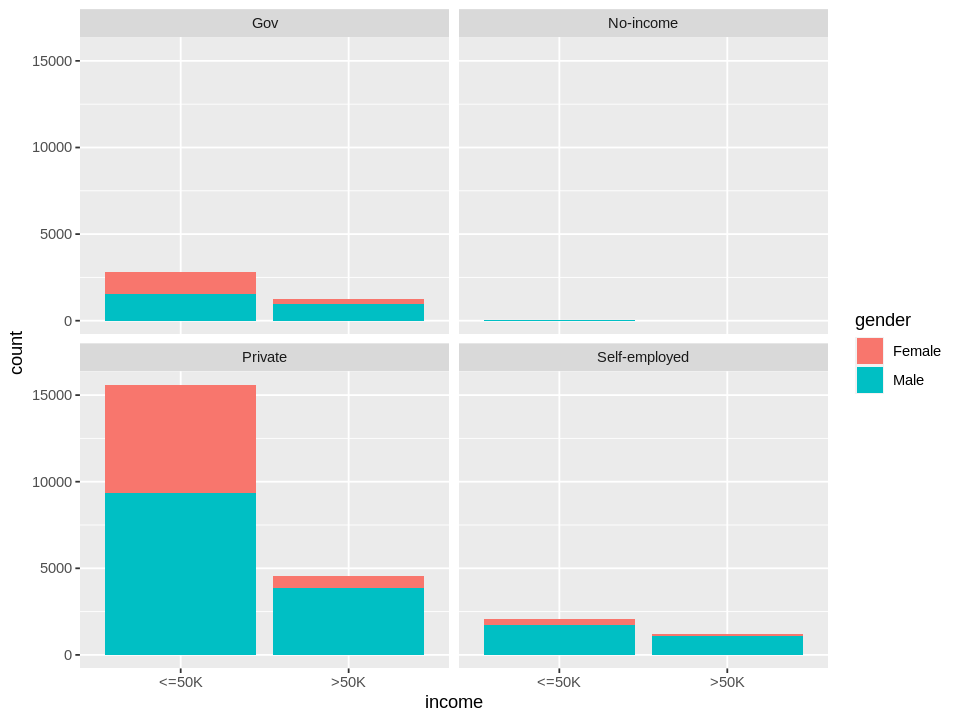

In [13]:
options(repr.plot.width = 8, repr.plot.height = 6)
income_data_plot <- income_data |>
                    ggplot() +
                    geom_bar(aes(x= income, fill = gender))  +
                    facet_wrap(~work_class)
income_data_plot

**FIGURE 1 - Bar charts comparing the differences in salary of male and female white collar professionals, sorted accordingly to their education levels.**

| Graph Title | Description |
| --- | --- |
| High-School | The people whose the highest level of education received is grade 12 or below, with 7th grade being the lowest, but never graduated from highschool. |
| Elementary | The people whose the highest level of education received is grade 4 or below, with 1st grade being the lowest. |
| Middle-School | The people whose the highest level of education received is grade 5 or 6. |
| Assoc-acdm | The people with an academic degree awarded after two or more years of study at a community college, technical college, vocational school, or university. |
| Assoc-voc | The people whose the highest level of education received is trade school. | 
| Bachelors | The people whose the highest level of education received is a Bachelor's Degree. |
| Doctorate | The people whose the highest level of education received is a Doctorate Degree. |
| HS-grad | The people whose the highest level of education received is a high school diploma. |
| Masters | The people whose the highest level of education received is a Master's Degree. |
| Preschool | The people whose the highest level of education received is pre-school. |
| Profs-school | The people whose the highest level of education received is post-graduate school (for example: medical, law, pharmacy, business, library, and social work schools). |
| Some-college | The people whose the highest level of education received is some postsecondary education and training but no completion and are no longer enrolled. |

**TABLE 3 - Table explaining the meaning of each category listed in Figure 1.**

From the bar plots above, there seems to be a pattern that women earn less than their male counterparts, regardless of their education levels. We will further confirm this with a hypothesis test using the Central Limit Theorem (CLT) and bootstrapping. 

### CLT

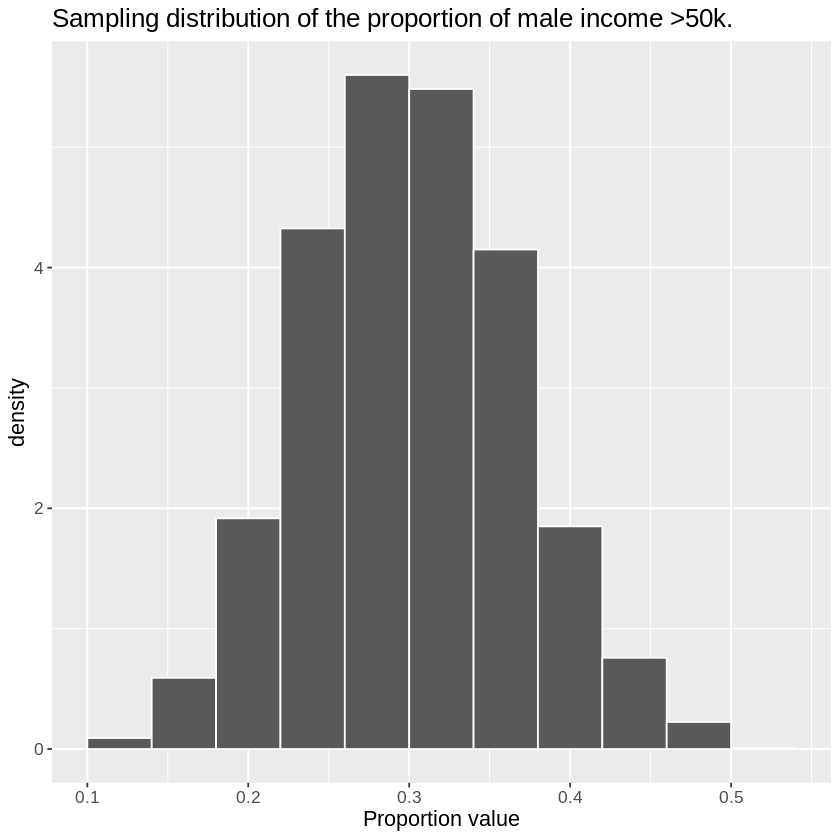

In [5]:
set.seed(100)
#Taking sample(male) of size 50
sample_male <- income_data |> 
                filter(gender == 'Male')
samples_size50 <- sample_male |>
                rep_sample_n(size = 50, reps= 3000)


#Plotting to check if the sample(male) follows an approximate normal distribution to use CLT

sampling_dist_male_size50 <-
    samples_size50 %>% 
    group_by(replicate) %>% 
    summarise(n_male = n() , 
              p = sum(income == '>50K')/(n_male), `.groups` = "drop") %>% 
    ggplot() + 
    geom_histogram(aes(x = p, y = ..density..), color="white", binwidth = 0.04) +
    theme(text = element_text(size = 13))+
    xlab("Proportion value") +
    ggtitle("Sampling distribution of the proportion of male income >50k.")


sampling_dist_male_size50

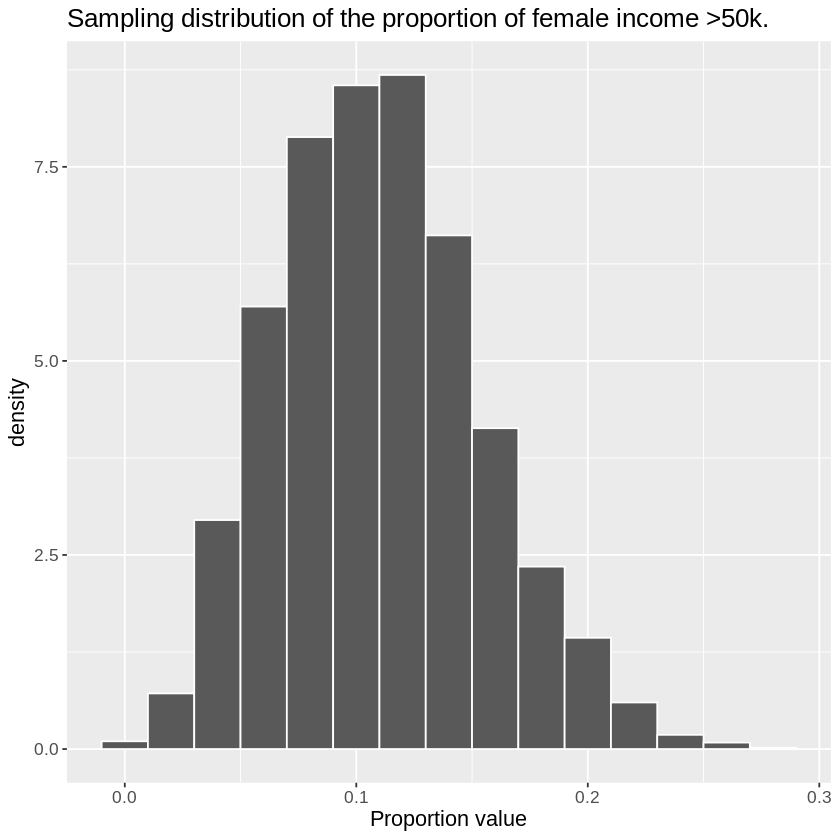

In [6]:
set.seed(100)
#Taking sample(female) of size 50
sample_female <- income_data |> 
                filter(gender == 'Female')
samples_size50 <- sample_female |>
                rep_sample_n(size = 50, reps= 3000)


#Plotting to check if the sample(female) follows an approximate normal distribution to use CLT

sampling_dist_female_size50 <-
    samples_size50 %>% 
    group_by(replicate) %>% 
    summarise(n_female = n() , 
              p = sum(income == '>50K')/(n_female), `.groups` = "drop") %>% 
    ggplot() + 
    geom_histogram(aes(x = p, y = ..density..), color="white", binwidth = 0.02) +
    theme(text = element_text(size = 13))+
    xlab("Proportion value") +
    ggtitle("Sampling distribution of the proportion of female income >50k.")


sampling_dist_female_size50

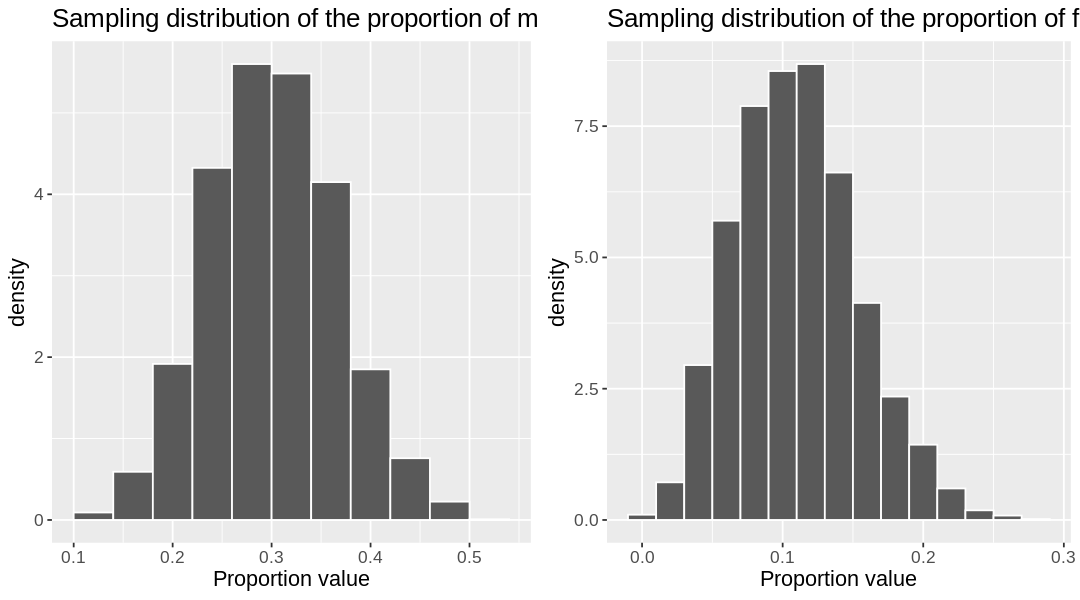

In [7]:
options(repr.plot.width = 9, repr.plot.height = 5) 
grid.arrange(sampling_dist_male_size50, sampling_dist_female_size50, ncol=2)

We begin by finding the sample proportions of $p_1$ (proportion of women that earn more than $\$50,000$ annually) and $p_2$ (proportion of men that earn more than $\$50,000$ annually). 

In [8]:
set.seed(100)
p_summary <- income_data |>
    summarise(n_female = sum(gender == 'Female'),
              n_male = sum(gender == 'Male'),
              p_female_above50k = sum(gender == 'Female' & income == '>50K')/(n_female),
              p_male_above50k = sum(gender == 'Male' & income == '>50K')/(n_male))
p_summary

n_female,n_male,p_female_above50k,p_male_above50k
<int>,<int>,<dbl>,<dbl>
9682,19488,0.1107209,0.3129618


**TABLE 4 - The summary of the number and the proportion of female and male professionals that earn more than $\$50,000$ annually**

In [9]:
#'p_diff' stores the observed difference in proportion.
#'p_diff_std_error' stores the sample standard error of the difference in proportions.
set.seed(100)
p_summary <-
    p_summary %>% 
    mutate(p_diff = p_male_above50k - p_female_above50k,
           p_diff_std_error = sqrt(p_male_above50k*(1-p_male_above50k)/n_male + p_female_above50k*(1-p_female_above50k)/n_female))
p_summary

n_female,n_male,p_female_above50k,p_male_above50k,p_diff,p_diff_std_error
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
9682,19488,0.1107209,0.3129618,0.2022409,0.004604656


**TABLE 5 - The summary of the number and the proportion of female and male professionals that earn more than $\$50,000$ annually, with the proportion difference and its standard error**

In [10]:
#Computing the confidence interval (95%)
set.seed(100)
p_summary <- 
     p_summary |> 
     mutate(lower_ci = qnorm(0.025, p_diff, p_diff_std_error),
            upper_ci = qnorm(0.975, p_diff, p_diff_std_error))
p_summary

n_female,n_male,p_female_above50k,p_male_above50k,p_diff,p_diff_std_error,lower_ci,upper_ci
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9682,19488,0.1107209,0.3129618,0.2022409,0.004604656,0.1932159,0.2112659


**TABLE 6 - The summary of the income dataset with a 95% confidence interval using the CLT**

### Bootstrapping

In [11]:
## Obtaining the 95% confidence interval of the difference of proportions via bootstrapping by generating 1000 samples 
set.seed(100)
diff_in_props_btsp_ci <- income_data |>
    specify(formula = income ~ gender, success='>50K') |>
    generate(type = 'bootstrap', reps = 1000, size = 50) |>
    calculate(stat = 'diff in props', order = c("Male", "Female")) |>
    get_ci()
diff_in_props_btsp_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.1930143,0.2112511


### Hypothesis Testing

- $H_0: p_{\text{female}} - p_{male} = 0$ vs $H_A: p_{female} - p_{male} < 0$

In [12]:
#Test Statistic
set.seed(100)

n_male <- nrow(sample_male)
n_female <- nrow(sample_female)


phat_male <- p_summary$p_male_above50k
phat_female <- p_summary$p_female_above50k

phat <- (n_male*phat_male + n_female*phat_female)/ (n_male + n_female)

test_statistic <- (phat_female - phat_male) / sqrt(phat * (1-phat) * (1/n_male + 1/n_female))



test_statistic

[1] -37.77566

In [13]:
#P-test

p_value <- pnorm(abs(test_statistic), lower.tail = FALSE)

p_value

[1] 0

In [14]:
p_summary <- p_summary |> 
            mutate(test_statistic = test_statistic,
                   p_value = p_value)

p_summary

n_female,n_male,p_female_above50k,p_male_above50k,p_diff,p_diff_std_error,lower_ci,upper_ci,test_statistic,p_value
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9682,19488,0.1107209,0.3129618,0.2022409,0.004604656,0.1932159,0.2112659,-37.77566,0


In [15]:
p_value_check <- tidy(
        prop.test(x = c(sum(sample_female$income == ">50K"), sum(sample_male$income == ">50K")), # an array with the number of successes in each sample
                  n = c(n_female,n_male), # an array with the size of each sample
                  alternative = 'less',
                  correct = FALSE)) 

p_value_check

estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.1107209,0.3129618,1427,0,1,-1,-0.1946669,2-sample test for equality of proportions without continuity correction,less


Pvalue close to 0 so at 5% significance level we reject the null! (main idea)

## Further analysis based on work class 

In [60]:
# Private
n_male_priv <- sample_male %>% 
              filter(work_class == "Private") %>% nrow()
n_female_priv <- sample_female %>% 
                filter(work_class == "Private") %>% nrow()

phat_male_priv <- mean(income_data %>% 
                       filter(work_class == "Private" & gender == "Male") %>% 
                       pull(income) == ">50K")
phat_female_priv <- mean(income_data %>% 
                        filter(work_class == "Private" & gender == "Female") %>% 
                        pull(income) == ">50K")

phat_priv <- (n_male_priv * phat_male_priv + n_female_priv * phat_female_priv) / (n_male_priv + n_female_priv)

test_statistic_priv <- (phat_female_priv - phat_male_priv) / sqrt(phat_priv * (1-phat_priv) * (1/n_male_priv + 1/n_female_priv))

p_value <- pnorm(abs(test_statistic_priv), lower.tail = FALSE)

p_summary_priv <- tibble(
                    n_female_priv = n_female_priv,
                    n_male_priv = n_male_priv,
                    p_female_above50k = phat_female_priv, 
                    p_male_above50k = phat_male_priv,
                    test_statistic = test_statistic_priv,
                    p_value = p_value)
                

p_summary_priv


n_female_priv,n_male_priv,p_female_above50k,p_male_above50k,test_statistic,p_value
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
6926,13209,0.09558187,0.2936634,-31.94784,2.894255e-224


In [61]:
#Gov
n_male_gov <- sample_male %>% 
              filter(work_class == "Gov") %>% nrow()
n_female_gov <- sample_female %>% 
                filter(work_class == "Gov") %>% nrow()

phat_male_gov <- mean(income_data %>% filter(work_class == "Gov" & gender == "Male") %>% pull(income) == ">50K")
phat_female_gov <- mean(income_data %>% filter(work_class == "Gov" & gender == "Female") %>% pull(income) == ">50K")

phat_gov <- (n_male_gov * phat_male_gov + n_female_gov * phat_female_gov) / (n_male_gov + n_female_gov)

test_statistic_gov <- (phat_female_gov - phat_male_gov) / sqrt(phat_gov * (1-phat_gov) * (1/n_male_gov + 1/n_female_gov))

p_value <- pnorm(abs(test_statistic_gov), lower.tail = FALSE)

p_summary_gov <- tibble(
                    n_female_gov = n_female_gov,
                    n_male_gov = n_male_gov,
                    p_female_above50k = phat_female_gov, 
                    p_male_above50k = phat_male_gov,
                    test_statistic = test_statistic_gov,
                    p_value = p_value)
                

p_summary_gov


n_female_gov,n_male_gov,p_female_above50k,p_male_above50k,test_statistic,p_value
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1536,2516,0.1673177,0.3895072,-14.89996,1.648953e-50


In [62]:
#proportion calculation
#self-employed

p_summary_self <- income_data |>
    summarise(n_female_self = sum(gender == 'Female' & work_class == 'Self-employed'),
              n_male_self = sum(gender == 'Male' & work_class == 'Self-employed'),
              p_female_above50k = sum(gender == 'Female' & income == '>50K' & work_class == 'Self-employed')/(n_female_self),
              p_male_above50k = sum(gender == 'Male' & income == '>50K' & work_class == 'Self-employed')/(n_male_self))

n_male_self <- p_summary_self$n_male_self
n_female_self <- p_summary_self$n_female_self


phat_male_self <- p_summary_self$p_male_above50k
phat_female_self <- p_summary_self$p_female_above50k

phat_self <- (n_male_self*phat_male_self + n_female_self*phat_female_self)/ (n_male_self + n_female_self)

test_statistic <- (phat_female_self - phat_male_self) / sqrt(phat_self * (1-phat_self) * (1/n_male_self + 1/n_female_self))

p_value_self <- pnorm(abs(test_statistic), lower.tail = FALSE)

p_summary_self <- p_summary_self |>
                mutate(test_statistic = test_statistic,
                   p_value = p_value_self)

p_summary_self
            


n_female_self,n_male_self,p_female_above50k,p_male_above50k,test_statistic,p_value
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
465,2839,0.2258065,0.3916872,-6.874145,3.118133e-12


**TABLE 7 - The bootstrapped confidence interval**

The CLT implies that sampling distribution for the sample statistic would tend to normality if the underlying assumptions are met. Since the method involving the CLT is much based on assumption, we used bootstrapping to verify the confidence interval generated using the CLT earlier. Both confidence intervals are relatively similar, hence, we can say that the CLT does apply in this case. However, this dataset is just a representative sample so there are still risks of inaccuracy using the CLT. This can later be addressed by using two-samples t-test.

## REFLECTION

Finding the conclusion to this question is important because it might be able to confirm the issue of workplace inequality and also gender inequality as a whole. Addressing this issue may involve implementing policies aimed at promoting gender equality in the workplace, as well as raising awareness and challenging cultural norms and biases that may be contributing to the problem.

## REFERENCES

Kochhar, R. (2023, March 1). The enduring grip of the gender pay gap. Pew Research Center's Social & Demographic Trends Project. Retrieved March 18, 2023, from https://www.pewresearch.org/social-trends/2023/03/01/the-enduring-grip-of-the-gender-pay-gap/ 

Kohavi, R., &amp; Becker, B. (1994). Census Income Data Set. UCI Machine Learning Repository: Census Income Data Set. Retrieved March 18, 2023, from https://archive.ics.uci.edu/ml/datasets/Census+Income 

United Nations. (2017). UN/DESA Policy Brief #53: Reflection on development policy in the 1970s and 1980s | Department of Economic and Social Affairs. United Nations. Retrieved March 18, 2023, from https://www.un.org/development/desa/dpad/publication/policy-brief-53-reflection-on-development-policy-in-the-1970s-and-1980s/ 